# Comparación de modelos de Machine Learning

Es importante comparar el rendimiento de distintos algoritmos de machine learning de forma consistente. El objetivo de este notebook es crear un template de prueba dicho cometido.

Cuando creemos un nuevo proyecto de ML, normalmente acabaremos con varios modelos que funcionen de manera aceptable para nuestro problema, aunque cada uno de esos modelos tenga distintas características de rendimiento.

Ya hemos visto que utilizando métodos como la validación cruzada nos ayudan a estimar cómo de preciso es nuestro modelo cuando tiene que predecir sobre datos "nunca vistos".

## Métodos

De la misma forma que visualizamos los datos cuando cogemos un nuevo dataset, tenemos que utilizar técnicas similares cuando ya hemos creado distintos modelos. Además de obtener un score, tenemos que comparar los resultados obtenidos por los modelos y decidir cuáles son los mejores (o el mejor).

## Consistencia

La forma correcta de comparar algoritmos de ML es asegurarse de que cada algoritmo se evalua de la misma forma en los mismos datos.

A continuación, veremos un ejemplo donde compararemos 6 algoritmos distintos:

1. Regresión Logística
2. Análisis linear discriminante
3. K-Nearest neighbors
4. Arboles de regresión y clasificación
5. Naive Bayes
6. Support Vector Machines

Para este problema utilizaremos el conocido dataset Pima Indians de diabetes. El problema tiene dos claes y ocho variables de entrada de distintas escalas.

El método utilizado para la evaluación cada algoritmo será el cross-validation, utilizando 10 folds para el mismo. Hay que configurar el algoritmo con el **mismo seed** para asegurar de que los splits se dividen de la misma manera y se lleva a cabo la evaluación de la misma forma.

In [2]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')


url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

seed = 7

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []
scoring = 'accuracy'



1) Evalua cada algoritmo utilizando cross-validation y muestra los resultados en pantalla.

In [3]:
for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = seed)
    cv_results = model_selection.cross_val_score(model,X,Y, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean()} ({cv_results.std()})")

LR: 0.7695146958304853 (0.04841051924567195)
LDA: 0.773462064251538 (0.05159180390446138)
KNN: 0.7265550239234451 (0.06182131406705549)
CART: 0.6913192071086808 (0.05887109162294331)
NB: 0.7551777170198223 (0.04276593954064409)
SVM: 0.6510252904989747 (0.07214083485055327)


2) Plotea los resultados en un whisker plot para ver la varianza de los scores por cada algoritmo de una forma visual.

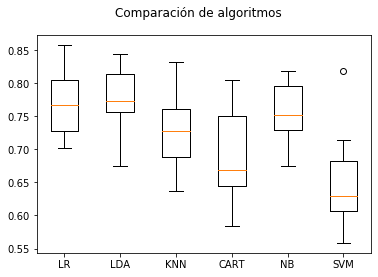

In [12]:
fig = plt.figure()
fig.suptitle('Comparación de algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

3) ¿Cuáles son los mejores modelos teniendo en cuenta los resultados obtenidos?

Este método se puede utilizar para una primera evaluación de los algoritmos. Una vez elijamos los mejores, podríamos proceder a mejorarlos, por ejemplo con la selección de los mejores hiperparámetros.

## Test de significación estadística

Una vez que hemos acabado de tunear nuestros modelos, puede que querramos demostrar que nuestro modelo funciona mejor que otro. Por ejemplo, si deseamos publicar los resultados de nuestro trabajo.

Para ello, hay que utilizar distintos test de significancia, siendo los más importantes, el test de McNemar y el test de Mann-Whitney-Wilcoxon.

### Test de McNemar

Especificamente, este test está recomendado para aquellos casos donde los algoritmos que están siendo comparados solo se pueden evaluar una sola vez. Por ejemplo, en un solo conjunto de test, sin tener la posibilidad de llevar a cabo un k-fold cross validation. Una utilidad clara de este test puede ser la comparación entre resultados de modelos de deep learning. En este caso, utilizaremos el test para comparar los resultados de dos algoritmos de clasificación.

#### Tabla de contingencias

    Instancia, Clas. 1 OK,	Clas. 2 Ok
    1           Yes              No
    2           No               No
    3           No	           Yes
    4           No	           No
    5           Yes	          Yes
    6           Yes	          Yes
    7           Yes	          Yes
    8           No	           No
    9           Yes	          No
    10		  Yes	         Yes
    
En esta tabla podemos ver que el clasificador 1 ha clasificado 6 datos correctamente (accuracy del 60%) y que el clasificador 2 ha obtenido 5 predicciones correctas (50%). Esta tabla se podría reducir a una tabla de contingencias, que es, precisamente, el formato en el que veremos los datos en el test de McNemar.

La tabla de contigencias tendría este aspecto: 

                Clas. 1 OK,	Clas. 2 NoOk
    Clas.1 Ok       Sí/Sí       Sí/No
    Clas.1 NoOk 	No/Sí       No/No

En la primera celda, indicaríamos cuáles han sido las instancias que tanto el clasificador 1, como el clasificador 2, han clasificado de forma correcta. El número total de instancias que ambos han clasificado de forma correcta es 4. Siguiendo el esquema indicado en la tabla anterior, obtendríamos los siguientes resultados:

                 Clas. 1 OK	Clas. 2 NoOk
       Clas.1 Ok      4          2
       Clas.1 NoOk    1          3

### Test estadístico de McNemar

Este test es poco intuitivo, aun así, es una de las técnicas de comparación de modelos más utilizada. En resumen, este test es un test de homogeneidad para la tabla de contingencias. Dicho en otras palabras, se fija en sí los modelos están "en desacuerdo" en la misma manera (o no).

Esta es la formula para el cálculo del test:

*McNemar_estadística = (Sí/No - No/Sí)^2 / (Sí/No + No/Sí)*

Donde Sí/No es el conteo de las instancias que el clasificador uno clasificó correctamente y el clasificador 2 los clasificó de forma incorrecta, y No/Yes indica el caso contrario.

Este test asume que tenemos al menos 25 datos y la estadística de test tiene una distribución Chi-Square de 1 grado de libertad.

##### Importante
Las celdas sí/sí y no/no no se utilizan. Podemos apreciar que la estadística solo se fija en la distintas predicciones correctas o incorrectas entre los dos modelos.
Por lo tanto, **hay que tener claro que no estamos reportando ni el accuracy ni los ratios de error.**

Partiendo de esta base, la hipótesis nula indica que ambos algoritmos "están en desacuerdo" en la misma cantidad.
Dado un nivel de significancia estadística, el p-valor generado por este test se puede interpretar de la siguiente manera:

* p > alpha: no podemos rechazar la H0, no hay diferencia en el desencuentro de ambos modelos
* p <= alpha: podemos rechazar H0, hay una diferencia significativa en el desacuerdo entre los modelos

#### Test de McNemar en Python

Este test se realiza mediante la función ncnemar() de statsmodels (http://www.statsmodels.org/dev/generated/statsmodels.stats.contingency_tables.mcnemar.html)

La función toma la tabla de contingencia como argumento y devuelve el cálculo de la estadística de test y el p-valor. 

Existen dos formas de utilizar este test dependiendo de la cantidad de datos que tengamos.
1. Si existe alguna celda en la tabla que se use para el cálculo de la estadística y que tenga un valor de conteo menor de 25, se utiliza una versión modificada del test, donde se calcula el p-valor utilizando una distribución binomial. Este es el comportamiento por defecto test:

In [ ]:
stat, p = mcnemar(table, exact = True)

2. De forma alternativa, si existe algun valor igual o mayor de 25, se puede utilizar el cálculo estándar del test:

In [ ]:
stat, p = mcnemar(table, exact = False, correction = True)

El siguiente ejemplo muestra como aplicar el test en una tabla de contingencia que habriámos obtenido como resultado de dos clasificadores. Como esta tabla tiene un número bajo en el conteo de las celdas de desacuerdo, se tiene que utilizar el método "exacto".

In [15]:
from statsmodels.stats.contingency_tables import mcnemar
# definimos la tabla de contingencia
table = [[4, 2],[1, 3]]

result = mcnemar(table, exact=True)

# resumen de los resultados obtenidos
print(f'statistic={result.statistic}, p-valor={result.pvalue}')

# interpretación del p-valor
alpha = 0.05
if result.pvalue > alpha:
    print('Misma proporción de errores (no podemos rechazar H0)')
else:
    print('Distinta proporción de errores (rechazamos H0)')

statistic=1.0, p-valor=1.0
Misma proporción de errores (no podemos rechazar H0)


3) Utiliza los datos resultados obtenidos por los dos mejores clasificadores de la pregunta dos, calcula la tabla de contingencia y utiliza el test de McNemar para comparar ambos modelos.

🥐